In [6]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0" # set to "" if on CPU
%pylab inline
from tardis import *
from scipy import sparse,ndimage
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
import time

Populating the interactive namespace from numpy and matplotlib


G:\Anaconda\envs\Tensorflow_1\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


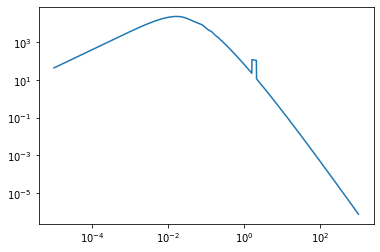

In [7]:
klin = np.loadtxt('F:/学习/天体物理/tardis-tf-master/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('F:/学习/天体物理/tardis-tf-master/data/Planck15_a1p00.txt').T[1]
plin[1300:1330] += 100#100
plt.loglog(klin,plin)
ipklin = iuspline(klin, plin)

In [8]:
n=32
uni = universe(bs=n, nc=n,z_f=2.0,ipklin = ipklin )
uni.evolv()

(32, 32, 32)
32768 65 32768
Total run time 5.06892204284668


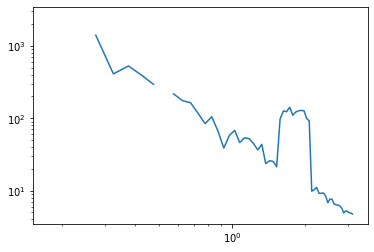

In [444]:
plt.loglog(uni.pk_true[0],uni.pk_true[1])
plt.show()

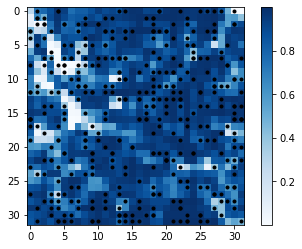

In [298]:
n_los = 400
mock_lya = lya_survey(uni,10,10,sm=0.5,n_skewers=n_los)
#powerlaw distribution of noise from snr_min = 2 to snr_max = 10
mock_lya.select_skewers()
#selecting LOS
imshow(np.exp(-1*uni.final_tau_RSD[0,:,:,0]),cmap="Blues")
colorbar()
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.')
#plot showing positions of LOS

In [327]:
mock_lya2 = lya_survey(uni,2,2,sm=0.5,n_skewers=n_los)
mock_lya2.select_skewers()
d4 = mock_lya2.vals_observed.reshape(-1,n)

In [337]:
data_coords = mock_lya.skewers_fin
d = mock_lya.vals_observed.reshape(-1,n)

map_x,map_y,map_z = meshgrid(arange(0,n),arange(0,n),arange(0,n))
m = np.zeros(shape=(n,n,n))
map_coords = np.vstack(list(map(np.ravel, [map_x,map_y,map_z]))).T

sigma2 = np.cov(d.flatten())

In [297]:
d = mock_lya.vals_observed.reshape(-1,n)
d_los = n/np.sqrt(n_los)
L_para = d_los
L_prep = d_los

Calculate $C_{MD}$ and $C_{DD}$

In [255]:
m_1 = map_coords[:,0]
d_1 = data_coords[:,0]
m_2 = map_coords[:,1]
d_2 = data_coords[:,1]
m_3 = map_coords[:,2]
d_3 = data_coords[:,2]

sigma2 = np.cov(d.flatten())
L_para = n/np.sqrt(n_los)
L_prep = n/np.sqrt(n_los)

In [256]:
start_time=time.time()
m_1_matrix = np.tile(m_1,(len(d_1),1)).T
d_1_matrix = np.tile(d_1,(len(m_1),1))
m_2_matrix = np.tile(m_2,(len(d_2),1)).T
d_2_matrix = np.tile(d_2,(len(m_2),1))

r_prep = (m_1_matrix-d_1_matrix)**2+(m_2_matrix-d_2_matrix)**2
del m_1_matrix,d_1_matrix,m_2_matrix,d_2_matrix

m_3_matrix = np.tile(m_3,(len(d_3),1)).T
d_3_matrix = np.tile(d_3,(len(m_3),1))

r_para = (m_3_matrix-d_3_matrix)**2
del m_3_matrix,d_3_matrix

C_MD = sigma2*np.exp(-r_para/L_para**2)*np.exp(-r_prep/L_para**2)
end_time=time.time()
print('Total run time:%f s'%(end_time-start_time))

Total run time:66.598858 s


In [257]:
start_time=time.time()

d_1_matrix2 = np.tile(d_1,(len(d_1),1))
d_1_matrix1 = d_1_matrix2.T

d_2_matrix2 = np.tile(d_2,(len(d_2),1))
d_2_matrix1 = d_2_matrix2.T

d_3_matrix2 = np.tile(d_3,(len(d_3),1))
d_3_matrix1 = d_3_matrix2.T

r_prep = (d_1_matrix1-d_1_matrix2)**2+(d_2_matrix1-d_2_matrix2)**2
r_para = (d_3_matrix1-d_3_matrix2)**2

C_DD = sigma2*np.exp(-r_para/L_para**2)*np.exp(-r_prep/L_para**2)

end_time=time.time()
print('Total run time:%f s'%(end_time-start_time))

Total run time:20.772578 s


In [258]:
noise=mock_lya.inverse_covar
N = 1/noise.values
N = diagflat(N)

In [259]:
start_time=time.time()

mat_inv = inv(C_DD+N)

end_time=time.time()
print('Total run time:%f s'%(end_time-start_time))

Total run time:59.941699 s


In [260]:
start_time=time.time()


kernel = np.dot(C_MD,mat_inv)

end_time=time.time()
print('Total run time:%f s'%(end_time-start_time))

Total run time:108.529042 s


In [264]:
start_time=time.time()

M = np.dot(kernel,d.flatten())
M_final=M.reshape(n,n,n)
M_final=array([M_final[:,i,:] for i in range(n)])

end_time=time.time()
print('Total run time:%f s'%(end_time-start_time))

Total run time:0.511687 s


In [265]:
d2 = mock_lya.vals_lya.reshape(-1,n)
M2 = np.dot(kernel,d2.flatten())
M2_final=M2.reshape(n,n,n)
M2_final=array([M2_final[:,i,:] for i in range(n)])

In [338]:
d3 = d/mean(d)-1
M3 = np.dot(kernel,d3.flatten())
M3_final=M3.reshape(n,n,n)
M3_final=array([M3_final[:,i,:] for i in range(n)])

In [340]:
d5 = d4/mean(d4)-1
M4 = np.dot(kernel,d5.flatten()).reshape(n,n,n)
M4 = array([M4[:,i,:] for i in range(n)])

In [346]:
M_snr2 = np.dot(kernel,d4.flatten()).reshape(n,n,n)
M_snr2 = array([M_snr2[:,i,:] for i in range(n)])

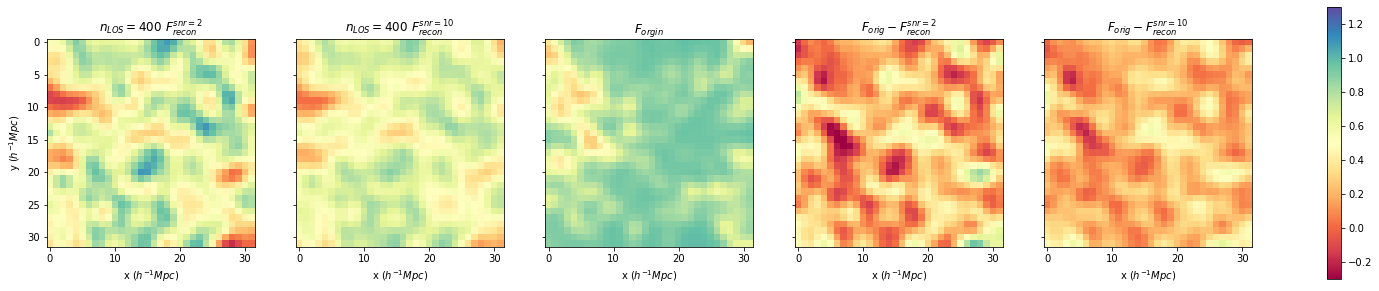

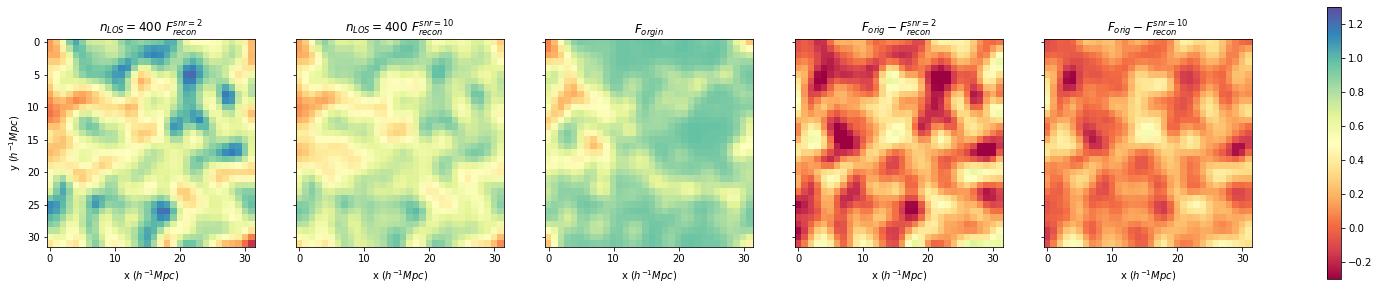

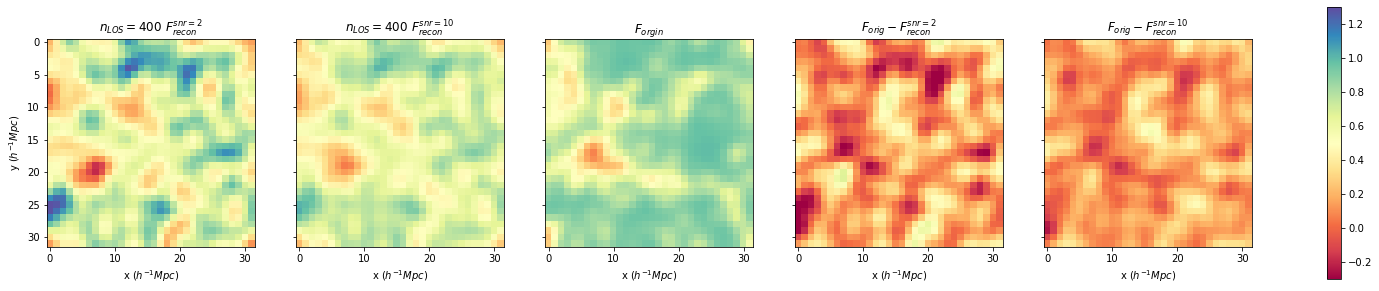

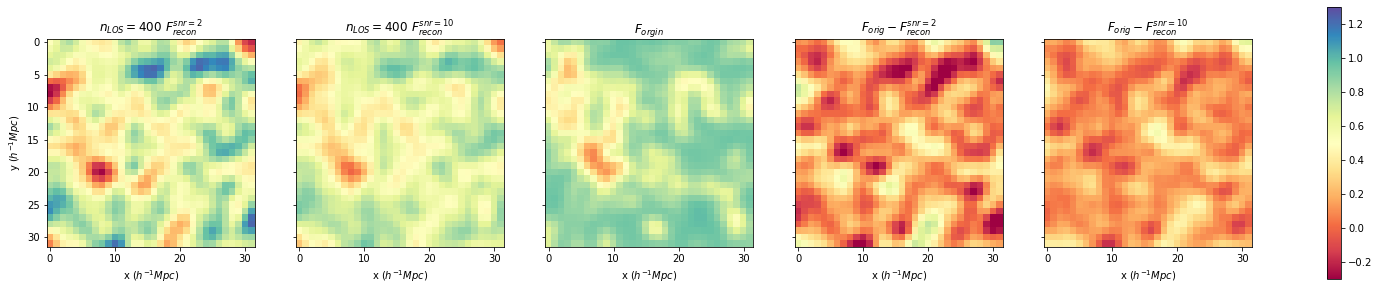

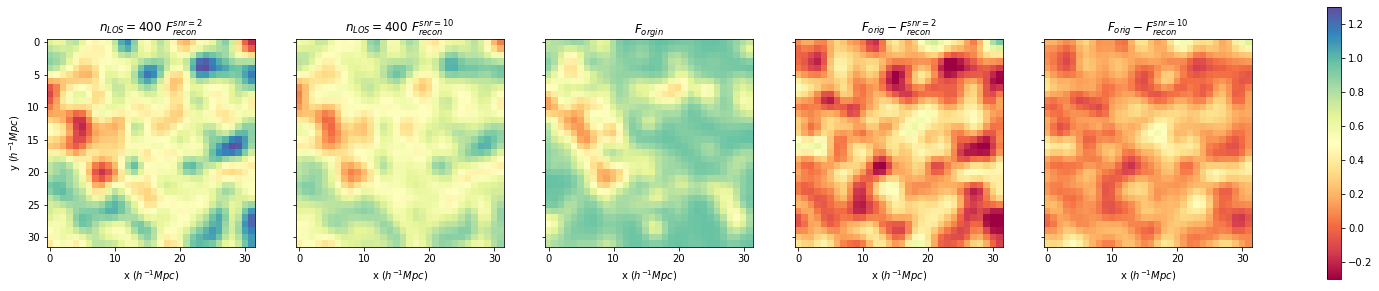

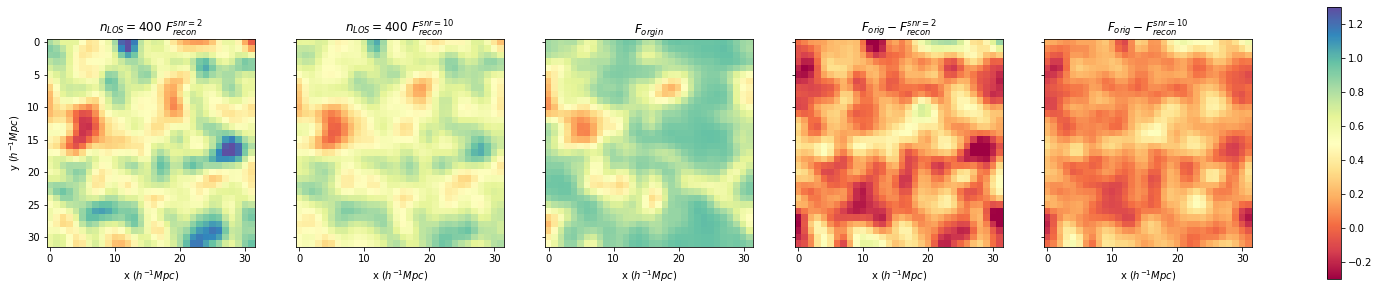

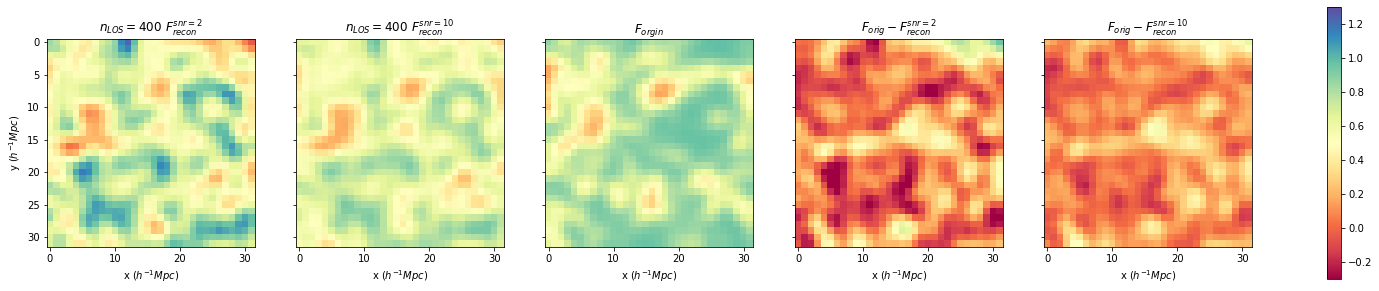

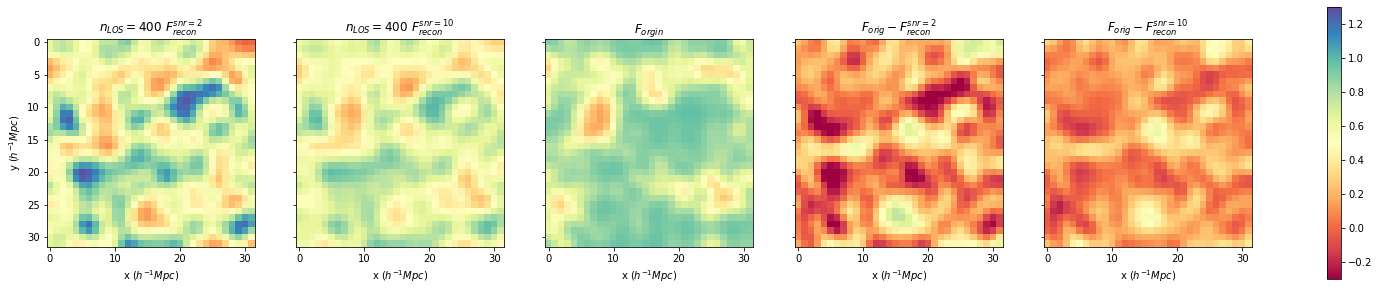

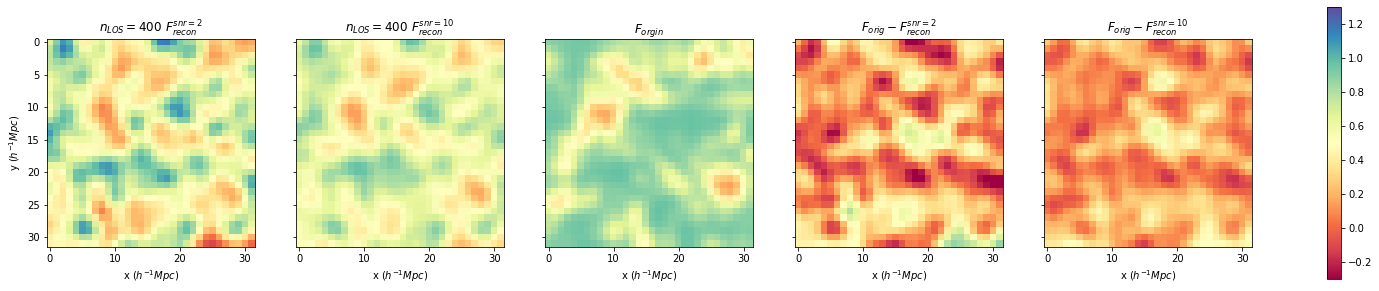

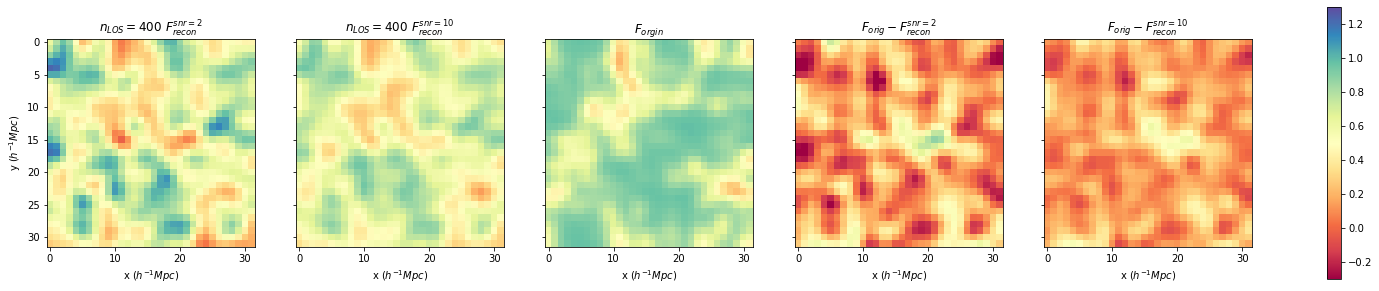

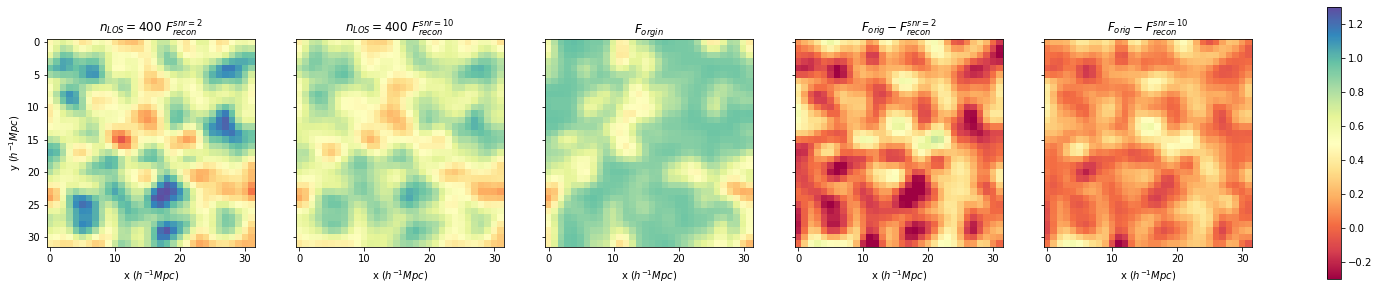

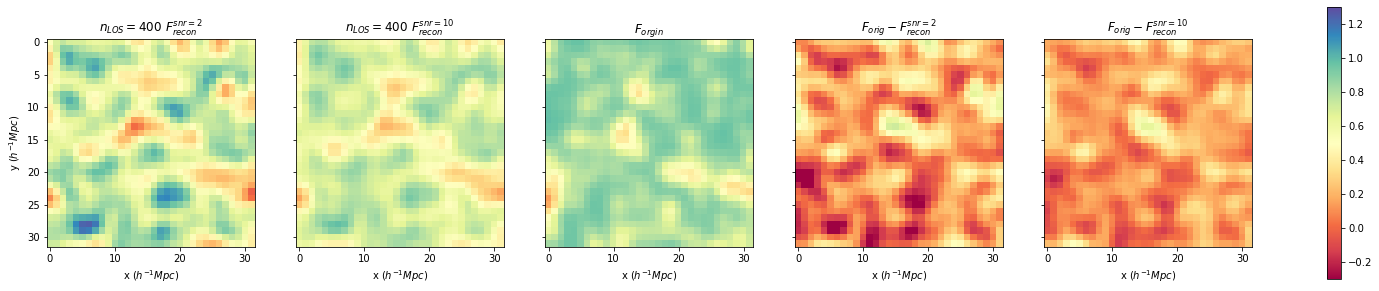

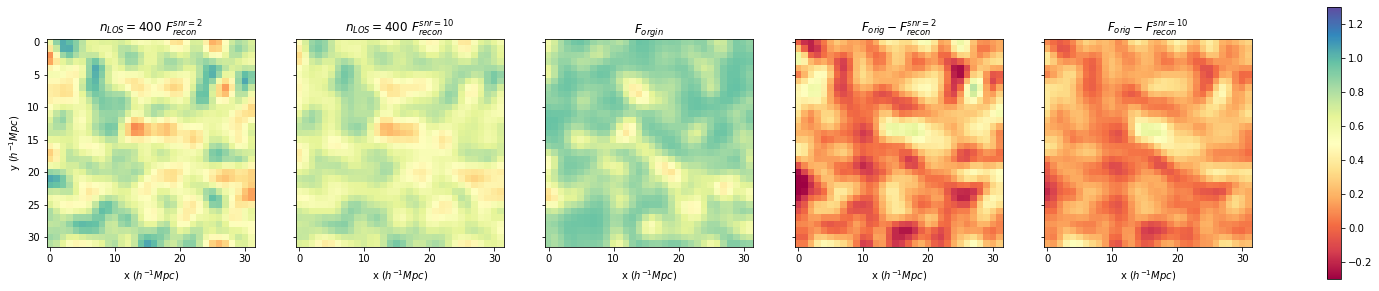

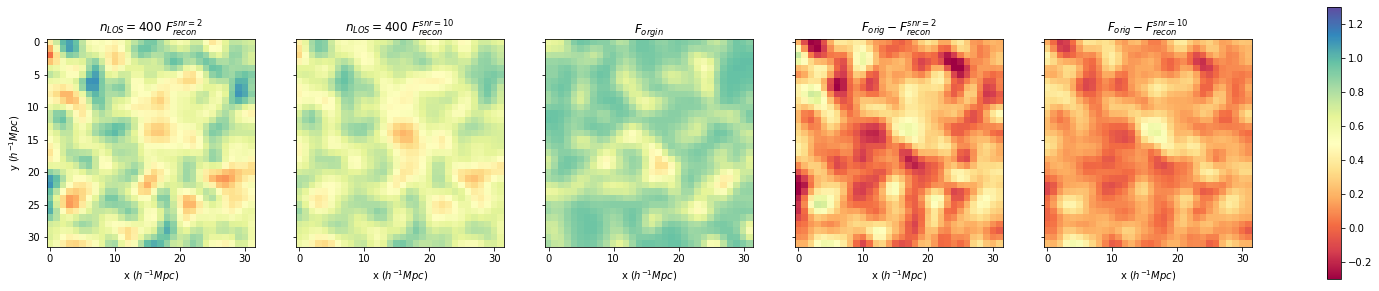

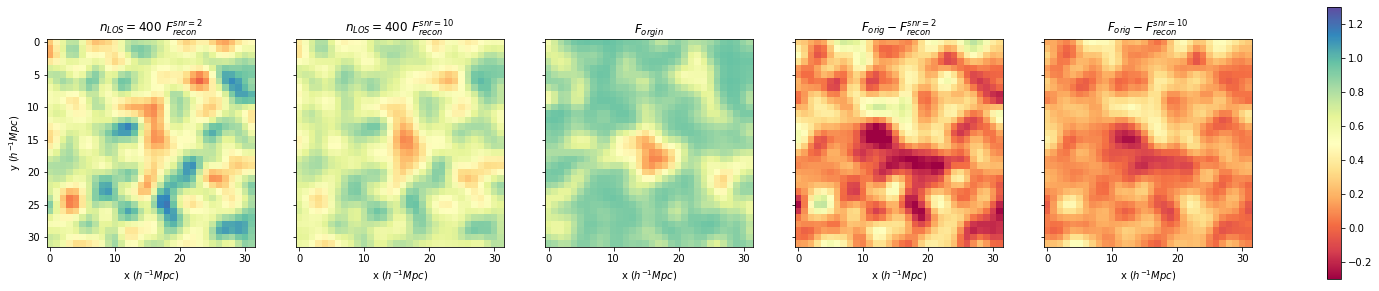

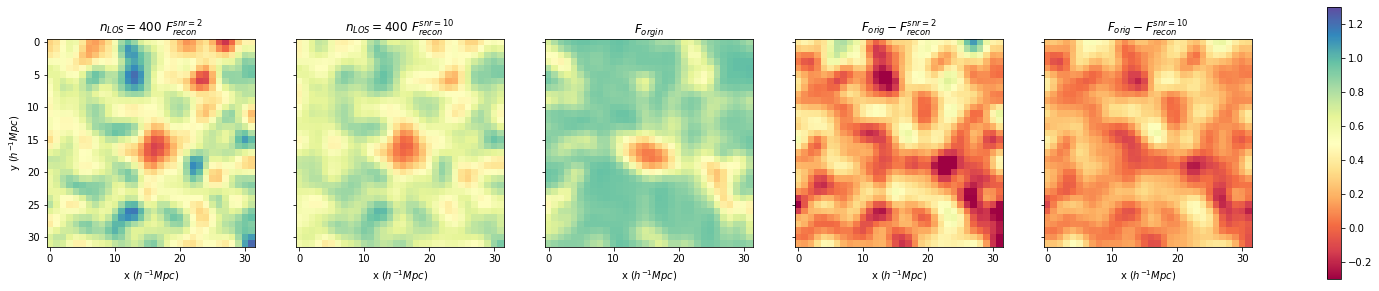

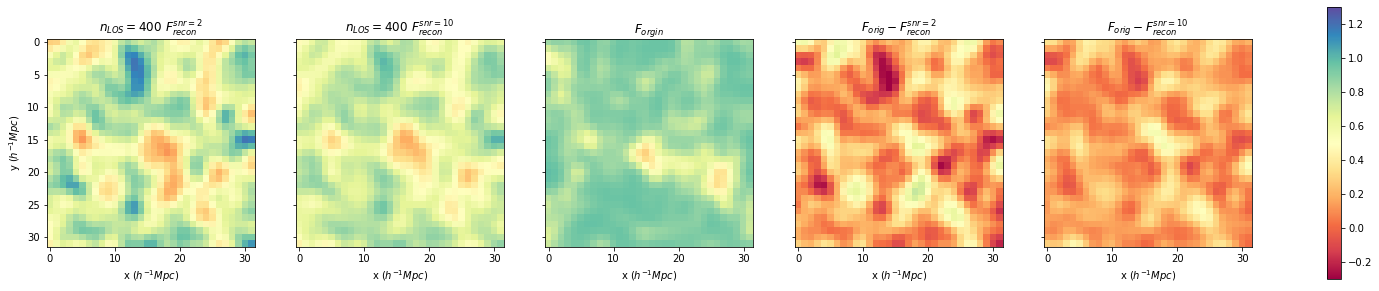

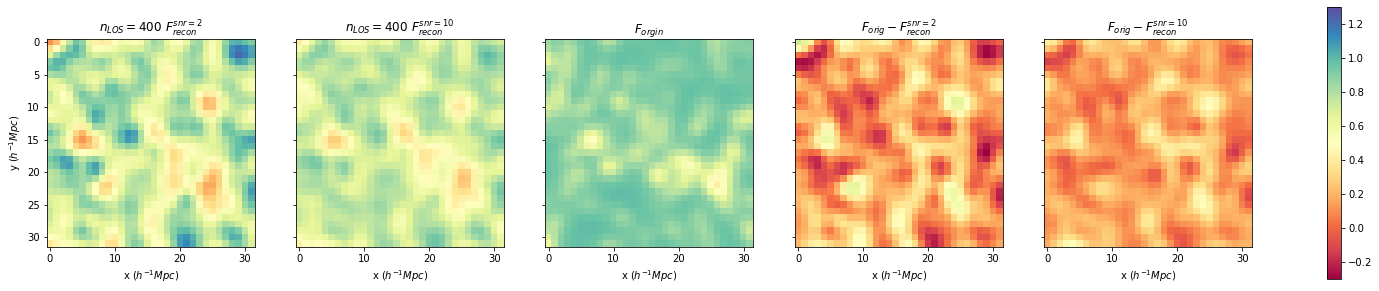

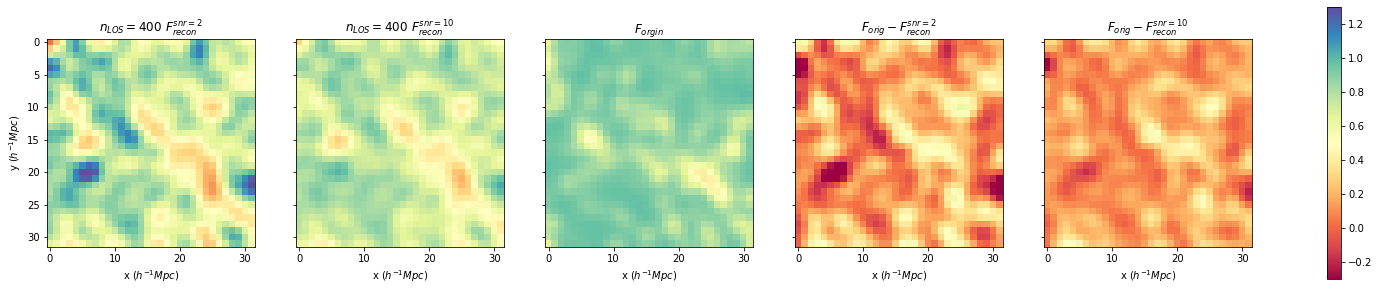

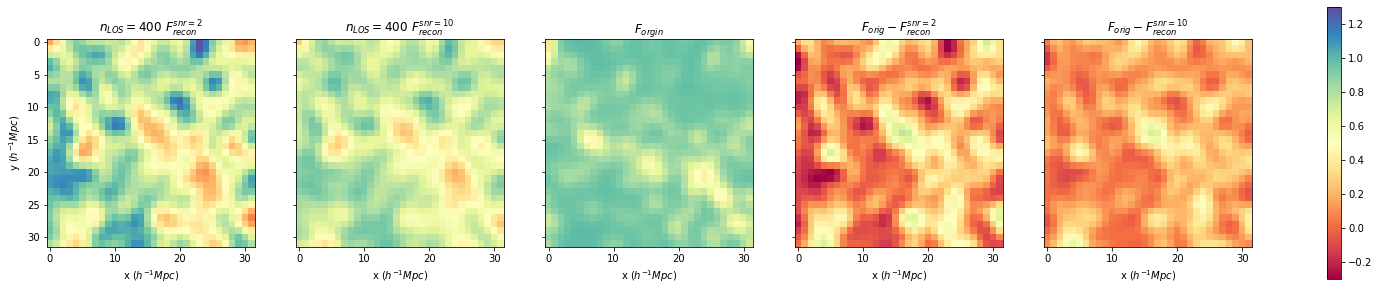

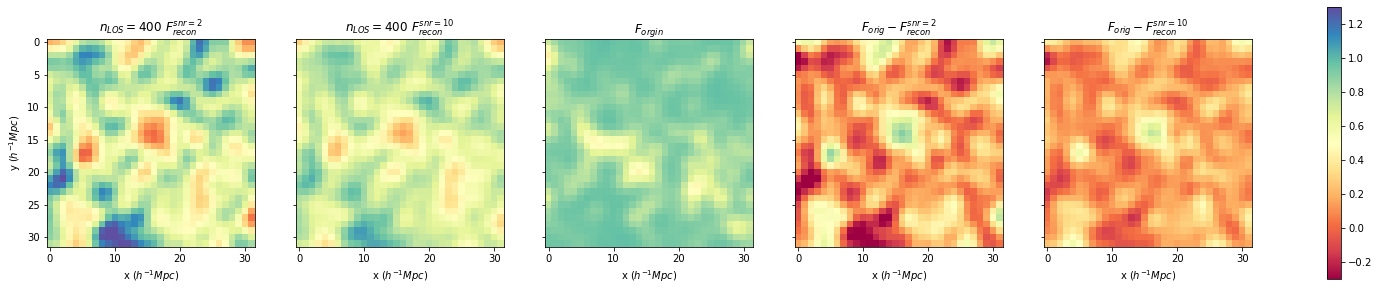

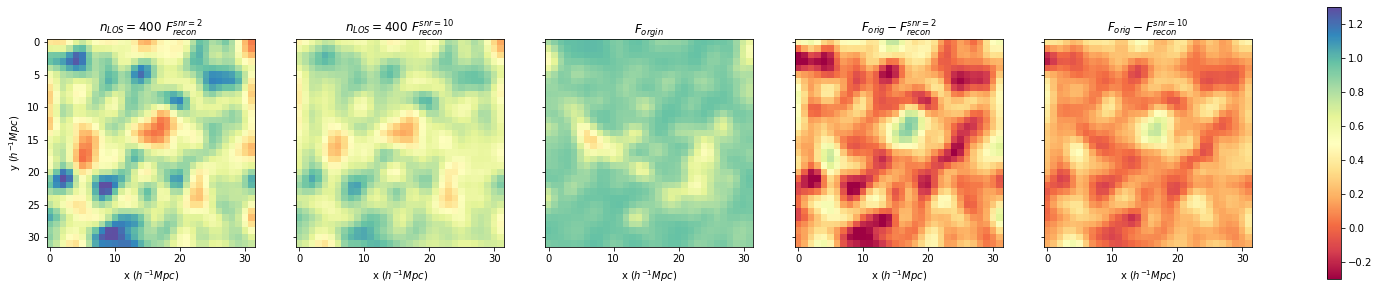

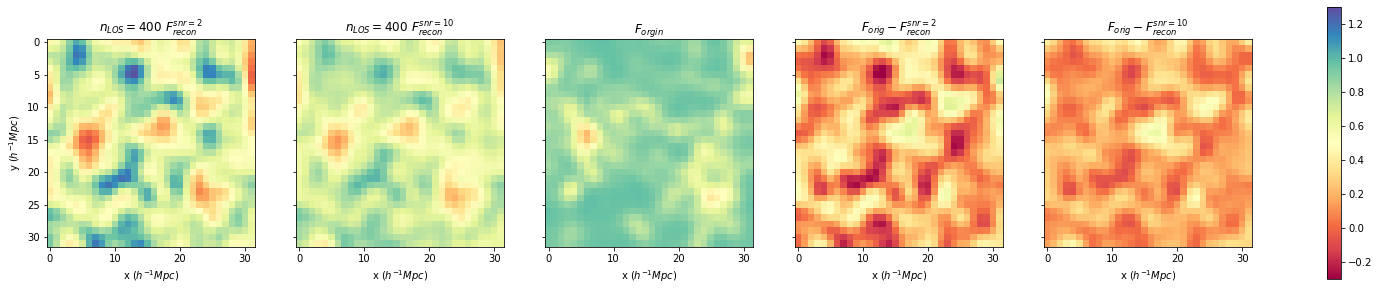

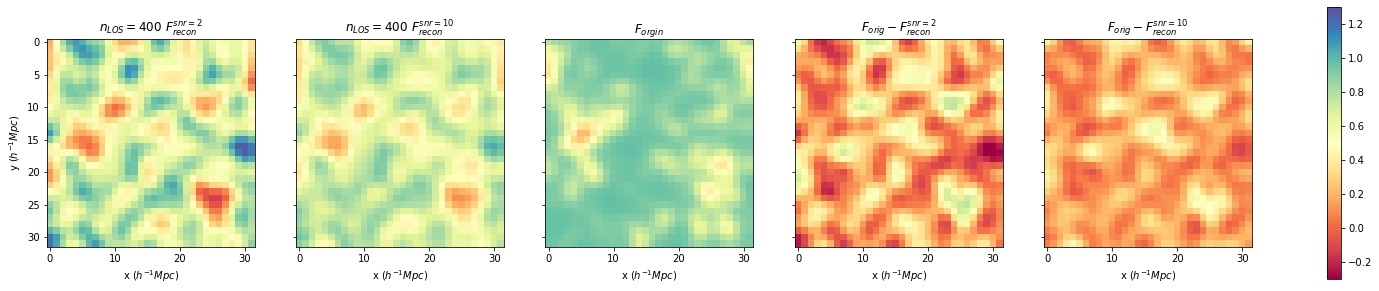

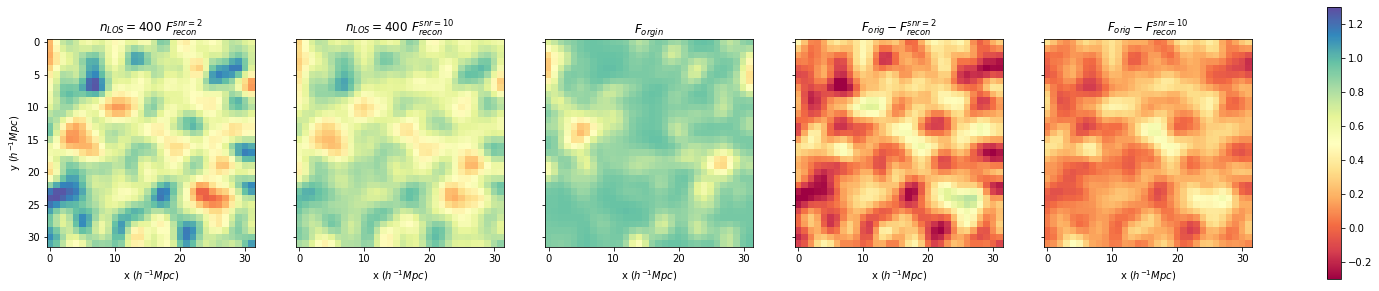

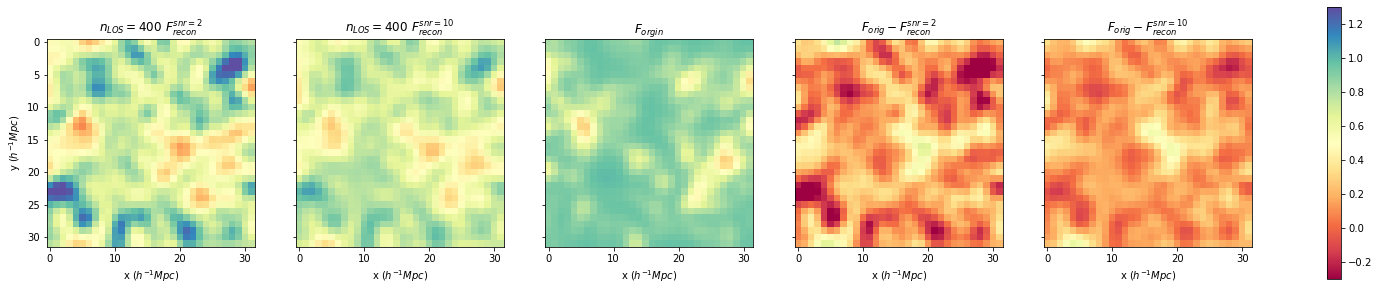

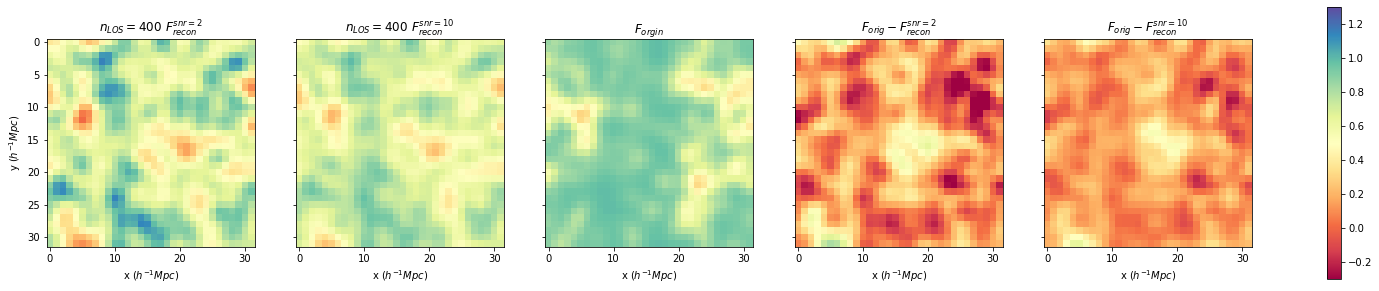

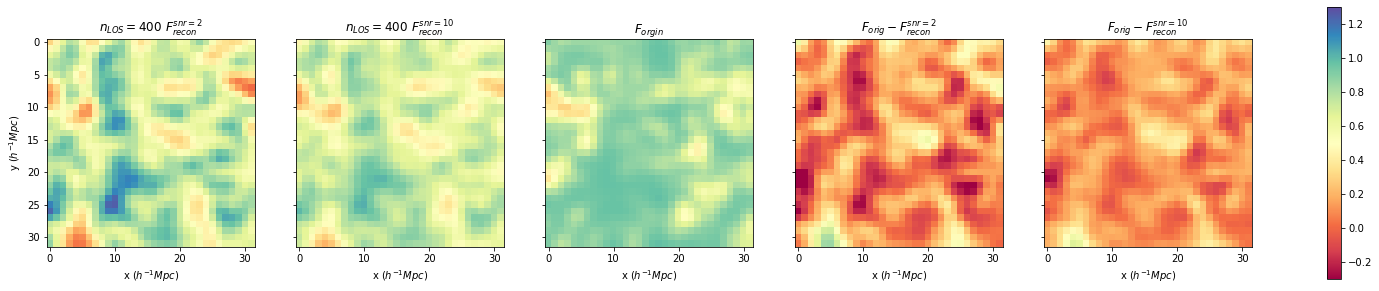

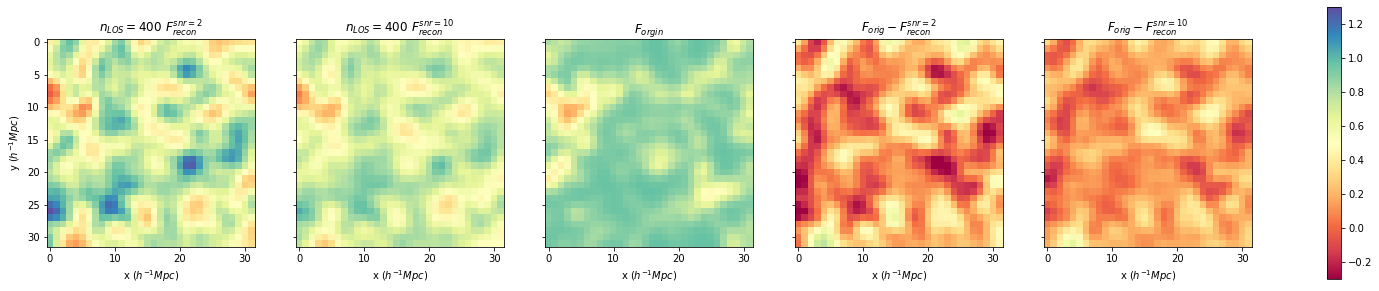

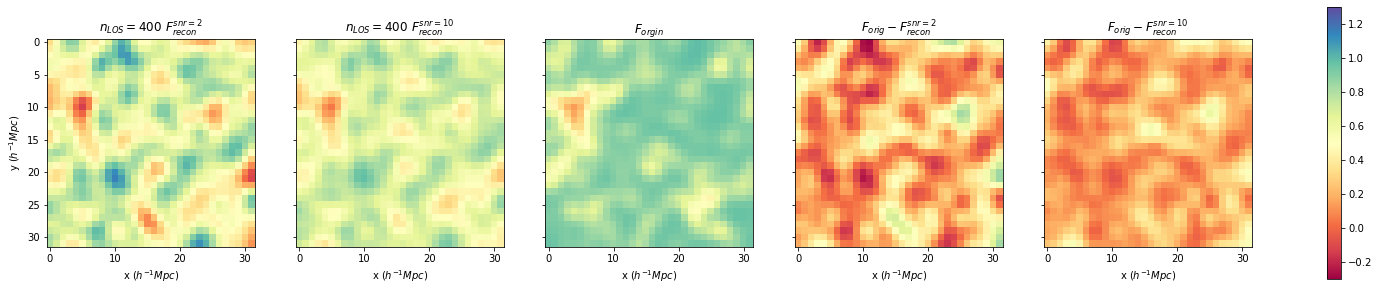

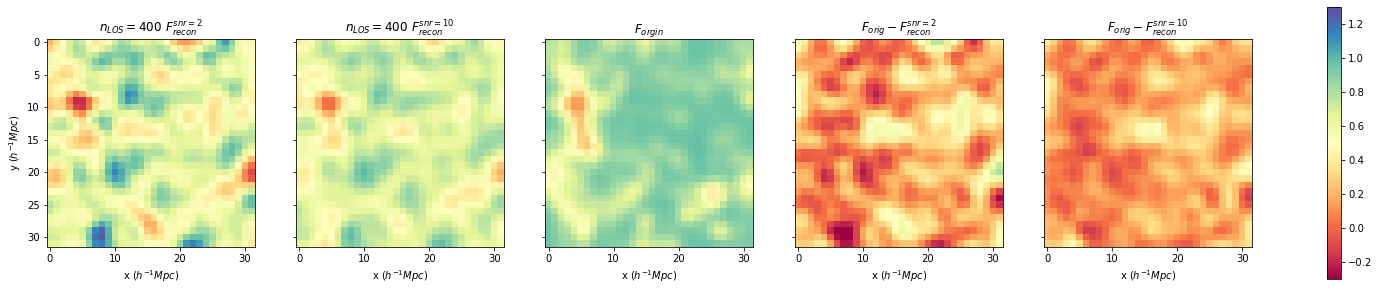

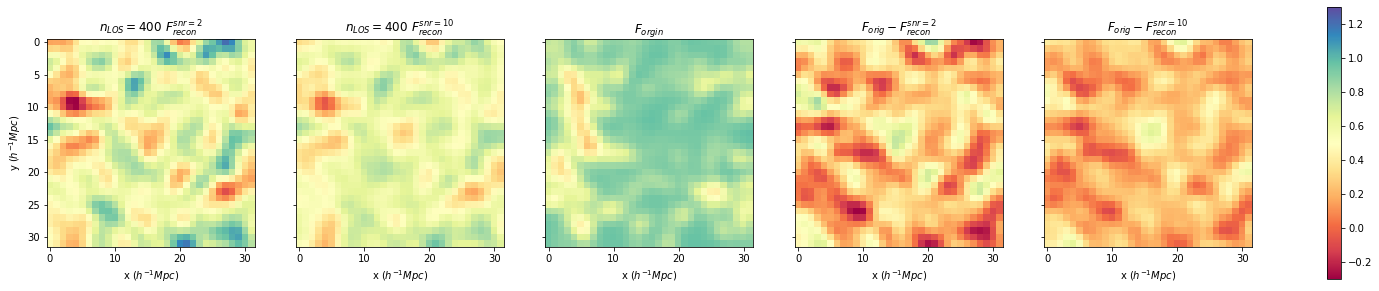

In [441]:
sigma=1
for i in range(n):
    
    vmin=-0.3
    vmax=1.3
    
    f, ax = plt.subplots(1, 5, sharey='row',figsize=(27,5))
    
    f1 = M_snr2[:,:,i]
    ga1 = ndimage.gaussian_filter(f1,sigma=sigma)
    surf1 = ax[0].imshow(ga1,vmin=vmin,vmax=vmax,cmap="Spectral")
    ax[0].invert_yaxis()
    ax[0].set_xlabel(r'x ($h^{-1}Mpc$)')
    ax[0].set_ylabel(r'y ($h^{-1}Mpc$)')
    ax[0].set_title(r'$n_{LOS}=%d\ F_{recon}^{snr=2}$'%n_los)

    f2 = M_final[:,:,i]
    ga2 = ndimage.gaussian_filter(f2,sigma=sigma)
    surf2 = ax[1].imshow(ga2,vmin=vmin,vmax=vmax,cmap="Spectral")
    ax[1].invert_yaxis()
    ax[1].set_xlabel(r'x ($h^{-1}Mpc$)')
    ax[1].set_title(r'$n_{LOS}=%d\ F_{recon}^{snr=10}$'%n_los)
    
    f3 = exp(-uni.final_tau_RSD[0,:,:,i])
    ga3 = ndimage.gaussian_filter(f3,sigma=sigma)
    surf3 = ax[2].imshow(ga3,vmin=vmin,vmax=vmax,cmap="Spectral")    ax[2].set_xlabel(r'x ($h^{-1}Mpc$)')    ax[2].set_title(r'$F_{orgin}$')
    ax[2].invert_yaxis()
    surf4 = ax[3].imshow(ga3-ga1,vmin=vmin,vmax=vmax,cmap="Spectral")
    ax[3].set_xlabel(r'x ($h^{-1}Mpc$)')
    ax[3].set_title('$F_{orig}-F_{recon}^{snr=2}$')
    
    surf5 = ax[4].imshow(ga3-ga2,vmin=vmin,vmax=vmax,cmap="Spectral")
    ax[4].set_xlabel(r'x ($h^{-1}Mpc$)')
    ax[4].set_title('$F_{orig}-F_{recon}^{snr=10}$')
    colorbar(surf5,ax=ax)
    show()

In [195]:
def pdf_plot(y,bins,**kwargs):
    fig=figure()
    ax = fig.add_subplot(111)
    out=ax.hist(y,bins=bins)
    close(fig)
    s = size(y)
    y = out[0]
    n = len(y)
    x = linspace((out[1][0]+out[1][1])/2,(out[1][-1]+out[1][-2])/2,n)
    y=y/s
    plot(x,y,**kwargs)

G:\Anaconda\envs\Tensorflow_1\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
G:\Anaconda\envs\Tensorflow_1\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
G:\Anaconda\envs\Tensorflow_1\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
G:\Anaconda\envs\Tensorflow_1\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log


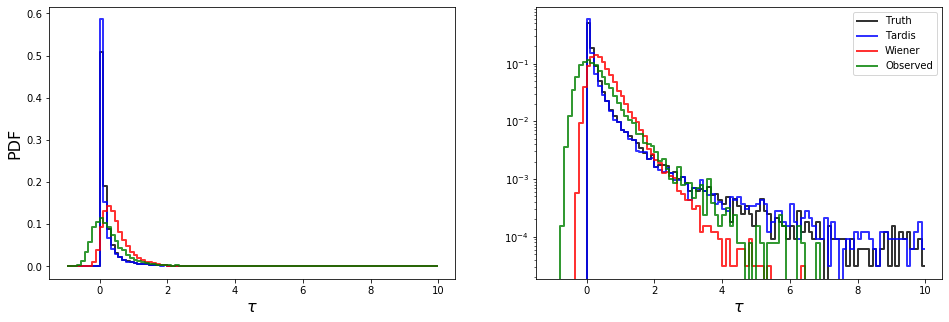

In [306]:
bins = linspace(-1,10,100)
figure(figsize=(16,5))
subplot(121)
pdf_plot(uni.final_tau_RSD.flatten(),bins=bins,color='black',linewidth=2,alpha=0.8,drawstyle='steps-mid',label='Truth')
pdf_plot(joint_recon.recon_RSD_tau[0].flatten(),bins=bins,color='blue',linewidth=2,alpha=0.8,drawstyle='steps-mid',label='Tardis')
pdf_plot(-log(M_final).flatten(),bins=bins,color='red',linewidth=2,alpha=0.8,drawstyle='steps-mid',label='Wiener')
pdf_plot(-log(mock_lya.vals_observed).flatten(),bins=bins,color='green',linewidth=2,alpha=0.8,drawstyle='steps-mid',label='Wiener')

xlabel(r'$\tau$',fontsize=16)
ylabel('PDF',fontsize=16)

subplot(122)
pdf_plot(uni.final_tau_RSD.flatten(),bins=bins,color='black',linewidth=2,alpha=0.8,drawstyle='steps-mid',label='Truth')
pdf_plot(joint_recon.recon_RSD_tau[0].flatten(),bins=bins,color='blue',linewidth=2,alpha=0.8,drawstyle='steps-mid',label='Tardis')
pdf_plot(-log(M_final).flatten(),bins=bins,color='red',linewidth=2,alpha=0.8,drawstyle='steps-mid',label='Wiener')
pdf_plot(-log(mock_lya.vals_observed).flatten(),bins=bins,color='green',linewidth=2,alpha=0.8,drawstyle='steps-mid',label='Observed')

legend()
xlabel(r'$\tau$',fontsize=16)
yscale('log')


Find the relation between flux and density

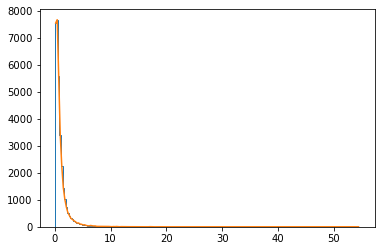

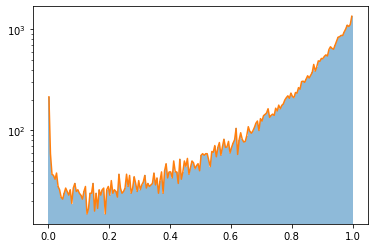

In [388]:
bins=200

density=uni.final_true.flatten()
density2=delete(density,where(density==0))
fig,ax=subplots(ncols=1)
out=ax.hist(density,bins=bins,histtype='step')
delta=linspace((out[1][0]+out[1][1])/2,(out[1][-1]+out[1][-2])/2,bins)
ax.plot(delta,out[0])
show()
p_delta=out[0]
show()

fig=figure()
ax=fig.add_subplot(111)
out=ax.hist(exp(-uni.final_tau_RSD[0]).flatten(),bins=bins,alpha=0.5)
flux=linspace((out[1][0]+out[1][1])/2,(out[1][-1]+out[1][-2])/2,bins)
ax.plot(flux,out[0])
ax.set_yscale("log")
show()
p_flux = out[0]

In [389]:
s1=0
a = flux[2]-flux[1]
for i in range(len(flux)):
    s1+=a*p_flux[i]
    
s2=0
a = delta[2]-delta[1]
for i in range(len(delta)):
    s2+=a*p_delta[i]

p_flux=p_flux/s1
p_delta=p_delta/s2

In [390]:
s1=0
a = flux[2]-flux[1]
for i in range(len(flux)):
    s1+=a*p_flux[i]
print(s1)

s2=0
a = delta[2]-delta[1]
for i in range(len(delta)):
    s2+=a*p_delta[i]
print(s2)

0.9999999999999999
1.000000000000002


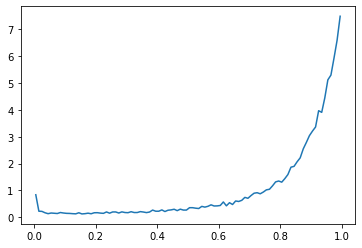

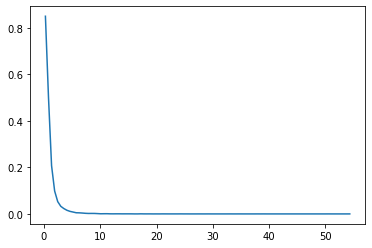

In [215]:
plot(flux,p_flux)
show()
plot(delta,p_delta)

For a given flux, the density can be solved from this equation:
$$\int_{F_{\min }}^{F_{*}} P_{F} d F=\int_{\Delta *}^{\Delta_{\mathrm{d}}} P_{\Delta} d \Delta$$

In [391]:
int_pf=array([])
a = flux[2]-flux[1]
for i in range(bins):
    temp = 0
    for n in range(i,bins):
        temp+=a*p_flux[n]
    int_pf=append(int_pf,temp)
    
int_pd=array([])
a = delta[2]-delta[1]
for j in range(bins):
    temp=0
    for n in range(j+1):
        temp+=a*p_delta[n]
    int_pd=append(int_pd,temp)    

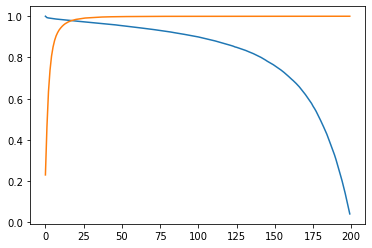

In [392]:
plot(int_pf)
plot(int_pd)

In [393]:
j=array([])
for i in range(bins):
    idx=where(abs(int_pf[i]-int_pd)==min(abs(int_pf[i]-int_pd)))
    idx=array(idx[0])
    if len(idx)>1:
        idx=idx[0]
    j=append(j,idx)
j=j.astype(int)
j.shape

(200,)

The relation between between flux and density can also be defined in this equation:
$$\tau=A\delta^\gamma$$
$$F=e^{-\tau}$$
$$\delta=(\frac{-ln(F)}{A})^{\frac{1}{\gamma}}$$

The two methods match well.

Text(0, 0.5, 'Flux')

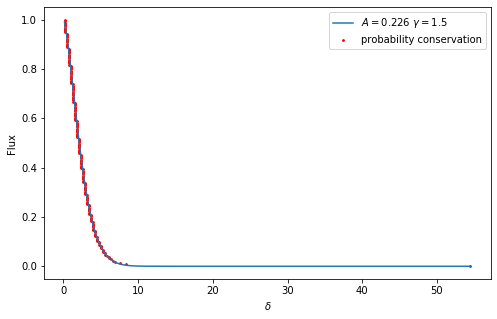

In [401]:
figure(figsize=(8,5))
scatter(delta[j],flux,s=3,c='red',label='probability conservation')
plot(delta,exp(-0.226*delta**1.5),label=r'$A=0.226\ \gamma=1.5$')
legend()
xlabel('$\delta$')
ylabel('Flux')

Transform flux to density and compare the density field with TARDIS.

In [404]:
density_recon = (-log(flux_delta_recon)/0.226)**(1/1.5)

G:\Anaconda\envs\Tensorflow_1\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
G:\Anaconda\envs\Tensorflow_1\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


Some flux values below 0 or over 1 make the corresponding density non-existent. So that I can’t show the density images directly because there are many missing pixels. Then I replaced the flux values below 0 with the minimal positive flux value and flux values over 1 with maximal value less than 1 to make the density existent, but I think it’s very rough. 

In [405]:
flux2=flux_delta_recon.copy()
flux2[flux2<0]=0.1
flux2[flux2==0.1]=flux2.min()
flux2[flux2>1]=1
density_recon2 = (-log(flux2)/0.226)**(1/1.5)

In [80]:
mock_gal = gal_survey(uni,32*32) #inverse number density
mock_gal.select_galaxies() #selects galaxies

loc = mock_gal.samples_n #invidual Galaxy locations

In [81]:
print("### Galaxies + Lyman Alpha ###")

pk_fac = 0.0

joint_recon = reconstruct_tardis(uni,lya=mock_lya,gal=mock_gal,specz_fac=0.0,specz_L2=False,lya_fac=1.,pk_fac=pk_fac,anneal_steps=[5,3,2,0],maxiter=[5,5,5,20])  #initializing with equal weight on galaxy field and lyman alpha field
joint_recon.initmodel() #initialize model
joint_recon.run_model() #run optimization

print("### Galaxies Only ###")
gal_recon = reconstruct_tardis(uni,lya=mock_lya,gal=mock_gal,specz_L2=True,specz_fac=1000.0,lya_fac=0.0,pk_fac=pk_fac,anneal_steps=[5,3,2,0],maxiter=[5,5,5,20]) 
gal_recon.initmodel() #initialize model
gal_recon.run_model() #run optimization

print("### Lyman Alpha Only ###")
lya_recon = reconstruct_tardis(uni,lya=mock_lya,gal=mock_gal, specz_fac=0.0,lya_fac=1.0,pk_fac=pk_fac,anneal_steps=[5,3,2,0],maxiter=[5,5,5,20])  
lya_recon.initmodel() #initialize model
lya_recon.run_model() #run optimization

### Galaxies + Lyman Alpha ###

(32, 32, 32)
32768 65 32768

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
r0,  5
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 131153.203125
  Number of iterations: 5
  Number of functions evaluations: 10
Run Time:  6.7970805168151855
r0,  3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 126793.515625
  Number of iterations: 5
  Number of functions evaluations: 9
Run Time:  15.424232006072998
r0,  2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 122171.273438
  Number of iterations: 5
  Number of functions evaluations: 9
Run Time:  23.44760036468506
r0,  0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIM

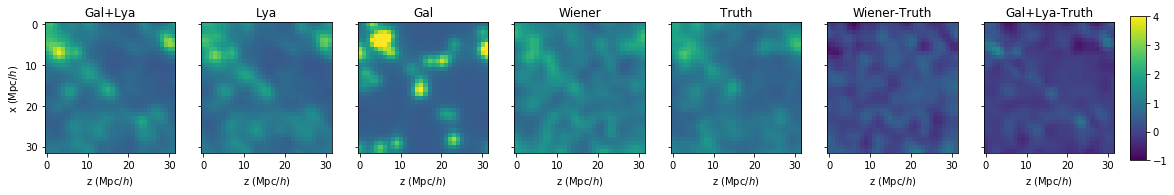

In [410]:
ax = 0
sm = 1.0
n=32
pylab.rcParams['figure.figsize'] = (22, 4.0)
f, axis = plt.subplots(1, 7, sharey='row')

vmin=-1
vmax=4

axis[0].imshow(ndimage.gaussian_filter(joint_recon.uni_rec.final_true[0],sm).sum(axis=ax)/n,vmin=vmin,vmax=vmax)
axis[0].set_title("Gal+Lya")
axis[0].set_xlabel("z (Mpc/$h$)")
axis[0].set_ylabel("x (Mpc/$h$)")

axis[1].imshow(ndimage.gaussian_filter(lya_recon.uni_rec.final_true[0],sm).sum(axis=ax)/n,vmin=vmin,vmax=vmax)
axis[1].set_title("Lya")
axis[1].set_xlabel("z (Mpc/$h$)")

axis[2].imshow(ndimage.gaussian_filter(gal_recon.uni_rec.final_true[0],sm).sum(axis=ax)/n,vmin=vmin,vmax=vmax)
axis[2].set_title("Gal")
axis[2].set_xlabel("z (Mpc/$h$)")

axis[3].imshow(ndimage.gaussian_filter(density_recon2,sm).sum(axis=ax)/n,vmin=vmin,vmax=vmax)
axis[3].set_title("Wiener")
axis[3].set_xlabel("z (Mpc/$h$)")

im = axis[4].imshow(ndimage.gaussian_filter(uni.final_true[0],sm).sum(axis=ax)/n,vmin=vmin,vmax=vmax)
axis[4].set_title("Truth")
axis[4].set_xlabel("z (Mpc/$h$)")

axis[5].imshow(ndimage.gaussian_filter(density_recon2,sm).sum(axis=ax)/n-
               ndimage.gaussian_filter(uni.final_true[0],sm).sum(axis=ax)/n,vmin=vmin,vmax=vmax)
axis[5].set_title("Wiener-Truth")
axis[5].set_xlabel("z (Mpc/$h$)")

axis[6].imshow(ndimage.gaussian_filter(joint_recon.uni_rec.final_true[0],sm).sum(axis=ax)/n-
              ndimage.gaussian_filter(uni.final_true[0],sm).sum(axis=ax)/n,vmin=vmin,vmax=vmax)
axis[6].set_title("Gal+Lya-Truth")
axis[6].set_xlabel("z (Mpc/$h$)")

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.81, 0.25, 0.01, 0.5])
f.colorbar(im, cax=cbar_ax)

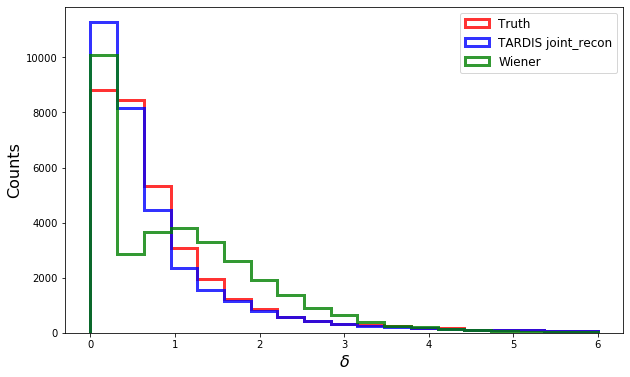

In [428]:
figure(figsize=(10,6))
bins = np.linspace(0,6,20)
plt.hist(uni.final_true[0].flatten(),bins=bins,alpha=0.8,color="red",histtype='step',linewidth=3,label='Truth')
plt.hist(joint_recon.recon_evolved[0].flatten(),bins=bins,alpha=0.8,color='blue',histtype='step',linewidth=3,label='TARDIS joint_recon')
plt.hist(density_recon2.flatten(),bins=bins,alpha=0.8,color='green',histtype='step',linewidth=3,label='Wiener')
legend(fontsize=12)
xlabel(r'$\delta$',fontsize=16)
ylabel('Counts',fontsize=16)
show()